In [1]:
import random

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge
import simplstyles

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord-light-talk')
sns.set_theme(style='whitegrid')
random.seed(42)

OSError: 'nord-talk-light' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [3]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_target = 0.1
noise_feature = 0.01

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score
use_ols = False

In [5]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target, noise_feature)

first of all lets verify that Ridge regression with $\alpha = 0$ indeed is equivalent to linear regression

In [6]:
# ridge = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
# ridge.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
# ridge_coef = ridge.coef_  # (n_features, n_targets)

In [7]:
# linear = LinearRegression()
# linear.fit(backend.to_numpy(Xs[0][:n_samples_train]), backend.to_numpy(Y[:n_samples_train]))
# linear_coef = linear.coef_  # (n_targets, n_features)
# # swap rows and columns
# linear_coef = linear_coef.T

In [8]:
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).mean())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).max())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).min())
# sns.displot(backend.to_numpy(linear_coef) - backend.to_numpy(ridge_coef))


compute on full feature sets for comparison

0.57413614
0.5752602


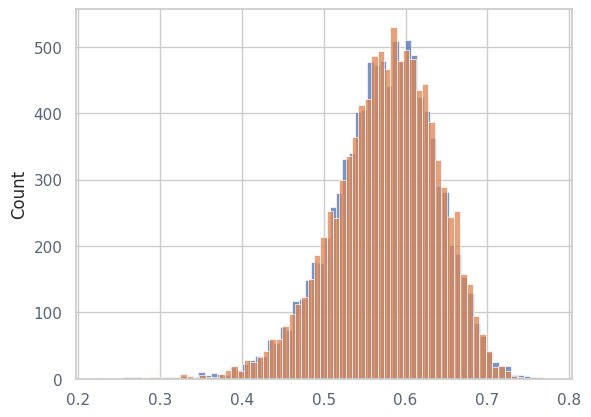

In [9]:
full_scores = []
for i in range(len(Xs)):
    full_model = RidgeCV(alphas=alphas, cv=cv,
                         solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    full_model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    full_score = full_model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    full_score = backend.to_numpy(full_score)
    print(full_score.mean())
    sns.histplot(full_score)
    full_scores.append(full_score)

# Feature to feature regression

In [10]:
if use_ols:
    feature_model = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
else:
    feature_model = RidgeCV(alphas=alphas, cv=cv, solver_params=(
        dict(warn=False, score_func=score_func, n_targets_batch=1000)))

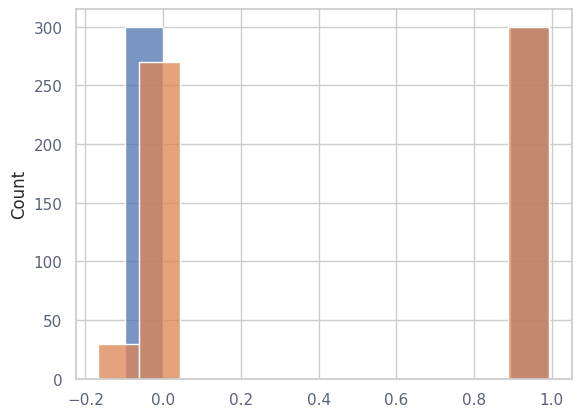

In [11]:
feature_scores = []
Xs_predict = []
for i in range(len(Xs)):
    i_from = (i + 1) % len(Xs)
    i_to = i
    feature_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

    X_predict = feature_model.predict(Xs[i_from])
    X_predict = backend.asarray(X_predict)
    Xs_predict.append(X_predict)
    feature_score = feature_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
    feature_score = backend.to_numpy(feature_score)
    feature_scores.append(feature_score)
    sns.histplot(feature_score)

Compute residuals

In [12]:
Xs_residual = []
for i in range(len(Xs)):
    X_residual = Xs[i] - Xs_predict[i]
    X_residual = backend.asarray(X_residual)
    Xs_residual.append(X_residual)

# Train residual model

0.28408942
0.28515273


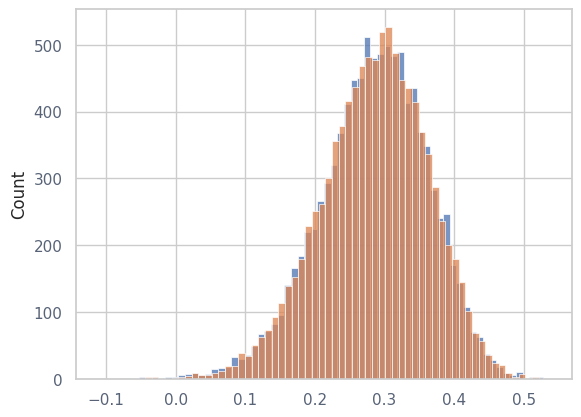

In [13]:
residual_scores = []
for i in range(len(Xs)):
    residual_model = RidgeCV(alphas=alphas, cv=cv,
                             solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    residual_model.fit(Xs_residual[i][:n_samples_train], Y[:n_samples_train])
    residual_score = residual_model.score(Xs_residual[i][n_samples_train:], Y[n_samples_train:])
    residual_score = backend.to_numpy(residual_score)
    print(residual_score.mean())
    sns.histplot(residual_score)
    residual_scores.append(residual_score)

# Plot Scores

In [14]:
import pandas as pd

scores = pd.DataFrame()
scores[r"$X_1\beta \approx Y$"] = full_scores[0]
scores[r"$X_2\beta \approx Y$"] = full_scores[1]
scores[r"$X_1\beta \approx X_2$"] = np.concatenate(
    [feature_scores[0], np.full(len(full_scores[0]) - len(feature_scores[0]), np.nan)])
scores[r"$X_2\beta \approx X_1$"] = np.concatenate(
    [feature_scores[1], np.full(len(full_scores[0]) - len(feature_scores[1]), np.nan)])
scores[r"$X_1'\beta \approx Y$"] = residual_scores[0]
scores[r"$X_2'\beta \approx Y$"] = residual_scores[1]

scores.head()

,$X_1\beta \approx Y$,$X_2\beta \approx Y$,$X_1\beta \approx X_2$,$X_2\beta \approx X_1$,$X_1'\beta \approx Y$,$X_2'\beta \approx Y$
0,0.564049,0.567542,0.988389,0.990190,0.305742,0.371992
1,0.550397,0.591632,0.983174,0.987134,0.213123,0.261317
2,0.617415,0.676098,0.982617,0.985536,0.387216,0.348287
3,0.577558,0.633658,0.983303,0.980200,0.200951,0.334597
4,0.527503,0.542591,0.992214,0.991104,0.160141,0.312897


Text(0.0, 1.0, 'Residual Method')

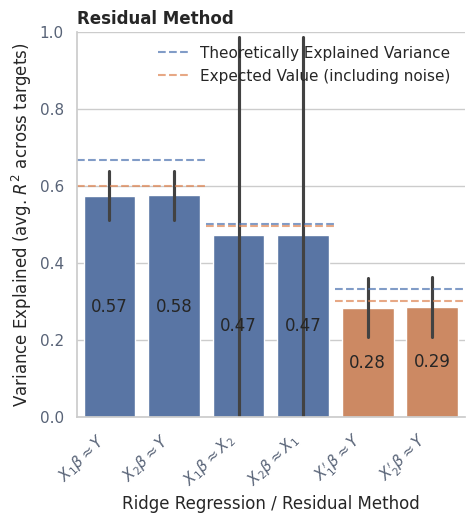

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(
    data=scores,
    ax=ax,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],
    errorbar="sd"
)

sns.despine()

# Add lines indicating the maximum possible height for each bar
theoretical_scores = [
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
    d_list[0] / (d_list[0] + d_list[1]),
    d_list[0] / (d_list[0] + d_list[2]),
    scalars[1],
    scalars[2],
]

for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    # Ensure index compatibility
    if column not in scores:
        print(f"Column '{column}' is not present in DataFrame. Available columns are: {list(scores.columns)}")
        continue

    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                label='Theoretically Explained Variance' if idx == 0 else "")

    # Use the mean of the column for positioning text
    mean_column_value = scores[column].mean()
    plt.text(idx, mean_column_value / 2, f"{mean_column_value:.2f}", ha='center', va='center')

# make xtickmarks diagonal
plt.xticks(range(len(scores.columns)), scores.columns, rotation=45, ha='right', va='top')

plt.ylim(0, 1)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel("Ridge Regression / Residual Method")
plt.title("Residual Method")